In [12]:
import warnings
warnings.simplefilter('ignore')

In [97]:
from datetime import datetime, timedelta
import itertools

import pandas as pd
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA

import time
import threading
import ipywidgets as widgets

In [3]:
repo = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19'
branch = f'{repo}/master'

df = (pd.read_csv(f'{branch}/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
      .drop(columns=['Province/State', 'Lat', 'Long'])
      .rename(columns={'Country/Region': 'country'})
      .groupby('country').sum())

# Add World and transpose
df = (df
      .append(df.sum(axis='index').rename('World'))
      .sort_index()
      .transpose()
      .set_index(pd.to_datetime(df.columns.values)))


df.info()
df.tail(3)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 382 entries, 2020-01-22 to 2021-02-06
Columns: 193 entries, Afghanistan to Zimbabwe
dtypes: int64(193)
memory usage: 579.0 KB


country,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,World,Yemen,Zambia,Zimbabwe
2021-02-04,55231,81993,108381,10137,19996,268,1961635,167568,28842,419801,...,43804,78916,1,128775,1957,161087,104857988,2122,59003,34171
2021-02-05,55265,83082,108629,10172,20030,277,1970009,167726,28848,421189,...,44303,78989,1,129231,1976,161559,105392577,2124,60427,34331
2021-02-06,55330,84212,108629,10206,20062,288,1976689,167937,28851,422522,...,44812,79045,1,129643,1985,162029,105764730,2127,61427,34487


## Time Series Forecasting
- [statsmodels v0.12.0 ARIMA](https://www.statsmodels.org/v0.12.0/generated/statsmodels.tsa.arima.model.ARIMA.html)
- [How to Create an ARIMA Model for Time Series Forecasting in Python](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)
- [How to Grid Search ARIMA Model Hyperparameters with Python](https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/)
 - [statsmodels ARIMA: how to get confidence interval?](https://stackoverflow.com/a/64283961/1592674)

In [112]:
def split(ts):
    """ Splitting 95%/5% because of little amount of data. """
    size = int(len(ts) * 0.95)
    train, test = ts[:size], ts[size:]
    return train, test


def mape(y1, y_pred):
    """ Mean absolute prediction error. """
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100


def predict_next_n_days(data, pdq, n=2):
    model = ARIMA(data, order=pdq, freq='D').fit()
    
    forecast = model.get_forecast(data.index[-1].date() + timedelta(days=n))
    yhat = forecast.predicted_mean
    yhat_conf_int = forecast.conf_int(alpha=0.05)

    ci_lo = yhat_conf_int.iloc[:, 0]
    ci_up = yhat_conf_int.iloc[:, 1]

    # PLOT
    fig, ax = plt.subplots(figsize=(12, 6))

    # ts
    _ = data['2020-11-01':].plot(ax=ax, label=data.name)

    # CI
    _ = ci_lo.plot(ax=ax, alpha=0.2, color='C0', label='')
    _ = ci_up.plot(ax=ax, alpha=0.2, color='C0', label='')

    # forecast
    _ = pd.concat([data.tail(1), yhat]).plot(ax=ax, ls='--', color='C1', label='forecast')

    # Fill
    _ = ax.fill_between(yhat_conf_int.index, ci_lo, ci_up, alpha=0.2, label='95% CI')

    ax.get_yaxis().set_major_formatter(mtick.EngFormatter())
    legend = ax.legend()
    sns.despine()
    fig.tight_layout()
    
    predicted_values = pd.concat([
        data.tail(1),
        yhat,
    ]).round(0).astype(int)
    
    return predicted_values

- [Interacting with output widgets from background threads](https://ipywidgets.readthedocs.io/en/latest/examples/Output%20Widget.html#Interacting-with-output-widgets-from-background-threads)

In [109]:
countries = df.columns.tolist()

w = widgets.Combobox(
#     value='World',
    placeholder='Choose Country',
    options=countries,
    description='Country:',
    ensure_option=True,
    disabled=False
)


@widgets.interact(country=w)
def prediction(country):
    if not country:
        return
    
    data = df[country]

    def arima(ts, test):
        """ Arima modeling for ts. """
        p = d = q = range(0, 8)
        pdq = tuple(itertools.product(p,d,q))
        total = len(pdq)
        
        # PROGRESS BAR WIDGET
        progress = widgets.FloatProgress(value=0, min=0, max=total, description='Loading: ')
        processed = 0
        
        def work(progress):
            total = len(pdq)
            while processed < total:
                time.sleep(0.2)
                progress.value = processed
            else:
                progress.value = total

        thread = threading.Thread(target=work, args=(progress,))
        display(progress)
        thread.start()

        # Determining the best parameters
        a = 99999
        param = tuple()
        for var in pdq:
            
            try:
                
                model = ARIMA(ts, order=var, freq='D')
                result = model.fit()
                
                if (result.aic <= a):
                    a = result.aic
                    param = var
                    
            except:
                continue
            
            finally:
                processed += 1
        
        print(param)
        model = ARIMA(ts, order=param, freq='D').fit()
        
        forecast = model_fit.get_forecast(len(test))
        yhat = forecast.predicted_mean

        # PLOT test vs predictions
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # ts
        _ = data['2020-11-01':].plot(ax=ax, label=ts.name)
        _ = yhat.plot(ax=ax, ls='--', color='C1', label='forecast')
        
    train, test = split(data)
    arima(train, test)

interactive(children=(Combobox(value='', description='Country:', ensure_option=True, options=('Afghanistan', '…

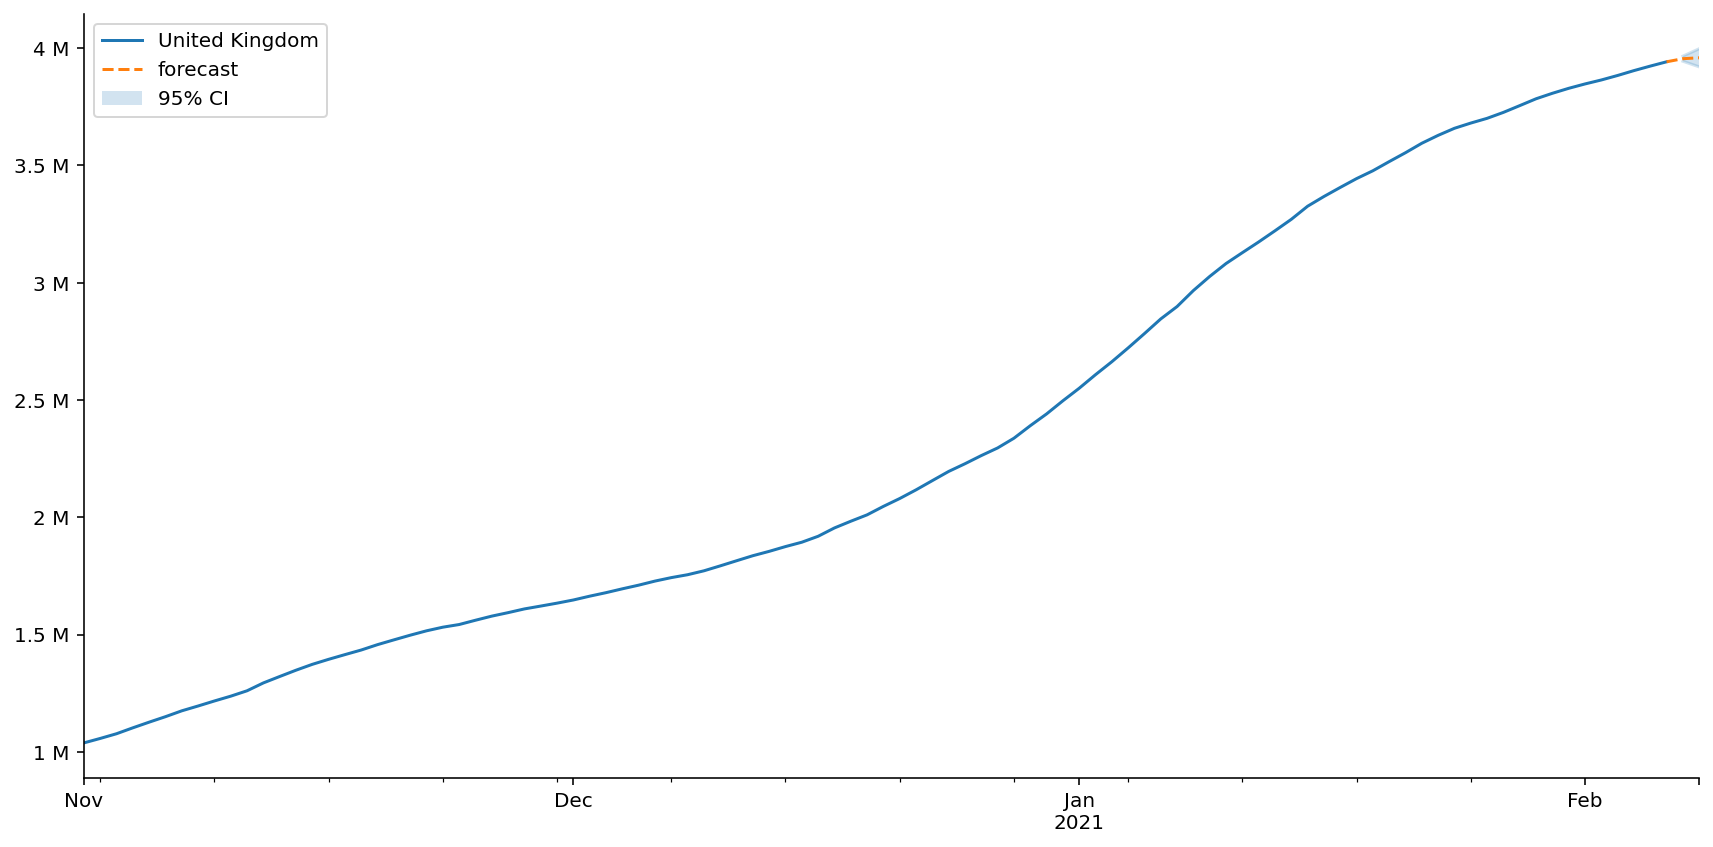

In [114]:
uk = df['United Kingdom']
prediction = predict_next_n_days(uk, pdq=(3, 6, 1), n=2)

In [115]:
prediction
(prediction.pct_change() * 100).round(1)

2021-02-06    3941273
2021-02-07    3954532
2021-02-08    3958302
dtype: int64

2021-02-06    NaN
2021-02-07    0.3
2021-02-08    0.1
dtype: float64

In [118]:
prediction.shift(-1) - prediction

2021-02-06    13259.0
2021-02-07     3770.0
2021-02-08        NaN
dtype: float64

## Voilà

- To learn about converting a Jupyter notebook into a voilá dashboard, you can refer to this [tutorial](https://blog.jupyter.org/and-voil%C3%A0-f6a2c08a4a93) by the Voilá team.
- Voilá [Documentation](https://voila.readthedocs.io/en/stable/using.html)
- This GitHub repo offers a step-by-step guide on how to [deploy your Voilá dashboard on Heroku](https://github.com/voila-dashboards/voila-heroku).


```bash
voila 05_interactive_ARIMA.ipynb
```